In [1]:
"""
Basic Topics to be a little familiar with:
- signal Processing: convolution, frequency space
- statistics/lin alg: gradient descent, sparsity, """
import numpy as np
import scipy
import pywt
from PIL import Image
from scipy import ndimage
from scipy.io import loadmat
from scipy import interpolate
import colour
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline   
import pdb



def IHT(y, K, Psi, PsiAdj, A, AAdj, MaxIter, x_init, x_true, ret_movie=False):
    """
    Solving: min_s || y - A*Psi_adj*s || ^ 2  s.t. ||s||_0 < K   and  s = Psi*x
    y: Destroyed image
    K: sparsity prior to enforce
    Psi: Wavelet function
    PsiAdj: Inverse Wavelet functions
    A: Linear operator that destroyed the image
    AAdj: Adjoint of linear operator that destroyed the image
    MaxIter: number of iterations to search for solutions
    x_init: initial guess of original image
    x_true: the true image for evaluating progress (MSE)
    ret_movie: return movie of learning process as numpy list of numpy arrays (each image)
    """
    
    # Initialize prediction image and it's WT image
    xstar = x_init
    s = Psi(x_init)
    # Video that tracks progress each iteration of training
    movie = []
    movie.append(np.copy(xstar))
    
    # Iterative process for solving 
    for i in range(MaxIter):
        eta = schedule_eta(epoch=i)
        g = AAdj(y - A(xstar))
        xstar = xstar + eta * g
        s = Psi(xstar)
        inds_k_comp = np.argpartition(np.abs(s.ravel()), -K, axis=None)[0:-K]
        s[np.unravel_index(inds_k_comp, s.shape)] = 0
        xstar = PsiAdj(s)
        
        MSE = np.mean((x_true-xstar)**2)
        print("Iteration: {}  MSE: {}".format(i, MSE))
        if ret_movie:
            movie.append(np.copy(xstar))
    if ret_movie:
        return xstar, movie
    return xstar




def IHT_demos(y, K, Psi, PsiAdj, A, AAdj, MaxIter, x_init, x_true, ret_movie=False):
    """
    This function is the save as IHT but for 3 channels
    """
    x_true = x_true.ravel()
    xstar = x_init
    movie = []
    movie.append(np.copy(xstar))
    for i in range(MaxIter):
        
        eta = schedule_eta(epoch=i)
        g = AAdj(y - A(xstar))
        xstar = xstar + eta * g

        sR = Psi(xstar[:,:, 0])
        sG = Psi(xstar[:,:, 1])
        sB = Psi(xstar[:,:, 2])
        # Here you have options for combining the 3 channels and choosing optimal coefficients
        #s = np.mean(np.vstack((sR.ravel(), sG.ravel(), sB.ravel())), axis=0)
        s = np.linalg.norm(np.vstack((sR.ravel(), sG.ravel(), sB.ravel())), axis=0)
        inds_k_comp = np.argpartition(np.abs(s), -K, axis=None)[0:-K]
        inds_k_comp = np.unravel_index(inds_k_comp, sR.shape)
        sR[inds_k_comp], sG[inds_k_comp], sB[inds_k_comp] = 0, 0, 0
        xstar[:,:,0] = PsiAdj(sR)
        xstar[:,:,1] = PsiAdj(sG)
        xstar[:,:,2] = PsiAdj(sB)
        MSE = np.mean((x_true-xstar.ravel())**2)
        print("epochs: {}  MSE: {}".format(i, MSE))
        if ret_movie:
            movie.append(np.copy(xstar))
    if ret_movie:
        return xstar, movie
    return xstar


def soft_thresh(arr, b=.5):
    """
    soft threshold function
    """
    max_pair = np.vstack((np.abs(arr)-.1, np.zeros(arr.shape)))
    return np.sign(arr)*np.amax(max_pair, axis=0)

def schedule_eta(epoch):
    """
    Schedules eta (the learning rate) each iteration of learning
    """
    eta0 = .5
    eta = eta0*(.98**epoch)
    if eta < 0.001:
        return 0.0001
    return eta



# LINEAR FUNCTIONS and their ADJOINTS

def blur(I, k0):
    b = ndimage.convolve(I, k0, mode='constant', cval=0.0)
    return b

def blur_adj(I, k0):
    bT = ndimage.convolve(I, k0[::-1, ::-1], mode='constant', cval=0.0)
    return bT

def corrupt(x, mask):
    currupted = x* mask
    return currupted

def corrupt_adj(x, mask):
    currupted_adj = x * mask
    return currupted_adj

def mosaik_f(I_c, rm, gm, bm):
    mos = np.zeros((I_c.shape[0],I_c.shape[1]))
    R = I_c[:,:, 0]
    G = I_c[:,:, 1]
    B = I_c[:,:, 2]
    mos[rm == 1] = R[rm == 1] # red
    mos[gm == 1] = G[gm == 1] # green
    mos[bm == 1] = B[bm == 1] # blue
    return mos

def mosaik_f_adj(M, rm, gm, bm):
    I_c = np.zeros((M.shape[0], M.shape[1], 3))
    R = I_c[:,:, 0]
    G = I_c[:,:, 1]
    B = I_c[:,:, 2]
    R[rm == 1] = M[rm == 1]
    G[gm == 1] = M[gm == 1]
    B[bm == 1] = M[bm == 1]

    I_c[:,:, 0] = R # red
    I_c[:,:, 1] = G # green
    I_c[:,:, 2] = B # blue

    return I_c

def make_rgb_mos_mask(shape):
    rm = np.zeros(shape)
    rm[1::2, 1::2] = 1
    bm = np.zeros(shape)
    bm[0::2, 0::2] = 1
    gm = np.ones(shape)
    gm[rm==1] = 0
    gm[bm==1] = 0
    return rm, gm, bm


def filter_wavedec2(coeffs, K):
    coeffs_fil = []
    return
    


def get_top_k_sample(arr: np.ndarray, k:int, ret_inds:bool=False, sort_k:bool=False, get_comp_k:bool=False) -> np.ndarray:
    """
    Takes the top k largest values of an arr 
    Note by using argpartion first then sorting we go from nlogn time to n+ klogk time
    """
    if get_comp_k:
        inds_k = np.argpartition(np.abs(arr), -k, axis=None)[0:-k] # Partition array at -k and save the k tail of array
    else:
        inds_k = np.argpartition(np.abs(arr), -k, axis=None)[-k:] # Partition array at -k and save the k tail of array
    if sort_k:
        #inds_k = np.argsort(arr[inds_k]) # get the indices of the array if it where in sorted order
        inds_k = np.argsort(np.take_along_axis(arr, inds_k, axis=None))
    #arr_k = arr[inds_k] # Get the tail k sorted
    arr_k = np.take_along_axis(arr, inds_k, axis=None)
    if ret_inds:
        return arr_k, inds_k
    return arr_k


def show_wavelet_decomp(img, level=1):
    coeffs = pywt.wavedec2(data=img, wavelet='db4', level=level)
    img,_ = pywt.coeffs_to_array(coeffs)
    plt.imshow(img)
    

def fill_holes(img):
    """
    Filles holes (where image is zero) with a nearest neighbor interpolation
    """
    y = np.arange(img.shape[0])
    x = np.arange(img.shape[1])
    grid_x, grid_y = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    points = np.argwhere(img > 0.0)
    values = img[points[:,0], points[:,1]]
    img = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
    return img
    
def play_movie(movie, name):
    """
    Saves movie of progress to a file
    movie: list of numpy arrays (each being a frame of the movie)
    name: title of the video file to save
    """
    cmap = 'viridis' if len(movie[0].shape)==3 else 'gray'
    fig = plt.figure()
    frames = []
    for i in range(len(movie)):
        frames.append([plt.imshow(movie[i], cmap=cmap,animated=True)])
    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
    ani.save('{name}.mp4'.format(name=name))
    plt.show()
        

In [6]:
# Get image to reconstruct in gray and color format. Scale images between 0 and 1
x_true = np.array(Image.open('plant.jpg').convert('L'), dtype=np.float32)/255.0
x_true_c = np.array(Image.open('plant.jpg'), dtype=np.float32)/255.0
# Get Blur Kernel from this mat file
mat_file = scipy.io.loadmat('data.mat')
k0 = mat_file['k0']
# Create a mask for destroying the images with holes (for inpainting)
mask = np.random.randint(2, size=x_true.shape)
# Create the blurry image 
y_blur = blur(I=x_true,k0=k0)
# Corrupt image with mask of random holes
y_corrupt = corrupt(x_true, mask)
# Generate RGB mosaic mask
rm, gm, bm = make_rgb_mos_mask(shape=x_true.shape)
y_mos = mosaik_f(I_c=x_true_c, rm=rm, gm=gm, bm=bm)
demos_init = mosaik_f_adj(M=y_mos, rm=rm, gm=gm, bm=bm)


# setup linear operators and their adjoints
A_blur = lambda x: blur(x, k0)
A_blur_adj = lambda x: blur_adj(x, k0)
A_corrupt = lambda x: corrupt(x, mask)
A_corrupt_adj = lambda x: corrupt_adj(x, mask)
A_mos = lambda x: mosaik_f(I_c=x, rm=rm, gm=gm, bm=bm)
A_mos_adj = lambda x: mosaik_f_adj(M=x, rm=rm, gm=gm, bm=bm)

# Setup wavelet functions
"""
To understand these wavelet functions I would highly recommend reading pywavelets documentation.
But basically wavedec2 and waverec2 are the DWT and IDWT.
coeffs_to_array and array_to_coeffs takes the tuples of coefficients of the DWT/IDWT and makes 
them into a matrix/ back into tuple of coeffs"""
DWT_decomposition_level = 3
s, coeff_slices = pywt.coeffs_to_array(coeffs=pywt.wavedec2(data=x_true, wavelet='db4', level=DWT_decomposition_level))
Psi = lambda x: pywt.coeffs_to_array(coeffs=pywt.wavedec2(data=x, wavelet='db4', level=DWT_decomposition_level))[0]
Psi_adj = lambda x: pywt.waverec2(coeffs=pywt.array_to_coeffs(x, coeff_slices= coeff_slices, output_format='wavedec2'), wavelet='db4')[:x_true.shape[0],:]








Text(0.5, 1.0, 'Mosaic Pattern')

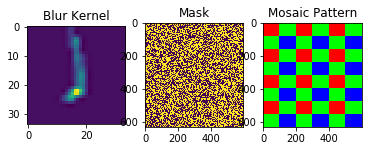

In [7]:
"""
This is a visualization of our 3 linear operators we are trying to reconstruct images from 
"""
plt.subplot(1,3,1)
plt.imshow(k0)
plt.title("Blur Kernel")
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title("Mask")
mosiac_one = np.ones((x_true.shape[0], x_true.shape[1],3))
mosiac_one[:,:,0] = rm
mosiac_one[:,:,1] = gm
mosiac_one[:,:,2] = bm
plt.subplot(1,3,3)
plt.imshow(mosiac_one)
plt.title("Mosaic Pattern")


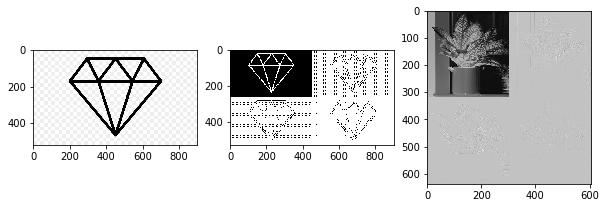

In [10]:
"""
Here we can visualize what a 2D wavelet transform is actually doing by seeing the 
Wavelet Transform Examples:
Top Left: Approximation image (low pass + downsample)
Top Right: Horizontal details
Bottom Left: vertical details
Bottom Right: Diagonol details
"""
diamond = np.array(Image.open('diamond.jpg').convert('L'), dtype=np.float32)/255.0
s_diamond = pywt.coeffs_to_array(coeffs=pywt.wavedec2(data=diamond, wavelet='db4', level=DWT_decomposition_level))[0]
plt.figure(figsize=(10,30))
plt.subplot(1,3,1)
plt.imshow(diamond, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(s_diamond>0.01, cmap='binary')
plt.subplot(1,3,3)
plt.imshow(s, cmap='binary')

In [ ]:
# Deblurring

kfrac = .05
x_init = y_blur
K = int(np.floor(kfrac * np.size(y_blur)))
deblurred, movie = IHT(y_blur, K, Psi, Psi_adj, A_blur, A_blur_adj, 300, x_init, x_true, ret_movie=True)
play_movie(movie, name='iht_deblur')

In [ ]:
# Inpainting
y_corrupt_fill = fill_holes(y_corrupt)
x_init = y_corrupt_fill
kfrac = .1
K = int(np.floor(kfrac * np.size(y_corrupt)))
inpainted, movie = IHT(y_corrupt, K, Psi, Psi_adj, A_corrupt, A_corrupt_adj, 300, x_init, x_true, ret_movie=True)
movie.insert(0,y_corrupt)
play_movie(movie, name='iht_inpainting')

In [ ]:
# Demosaicing
dmR,dmG,dmB = fill_holes(demos_init[:,:,0]), fill_holes(demos_init[:,:,1]), fill_holes(demos_init[:,:,2])
x_init_filled = np.zeros(demos_init.shape)
x_init_filled[:,:,0], x_init_filled[:,:,1], x_init_filled[:,:,2] = dmR,dmG,dmB
kfrac = .05
K = int(np.floor(kfrac * np.size(y_mos)))
demos, movie = IHT_demos(y_mos, K, Psi, Psi_adj, A_mos, A_mos_adj, 300, x_init=demos_init, x_true=x_true_c, ret_movie=True)
movie.insert(0,demos_init)
play_movie(movie, name='iht_demos')

In [ ]:
scale = 30
plt.figure(figsize=(1*scale,3*scale))
plt.subplot(1,4,1)
plt.imshow(x_true_c)
plt.subplot(1,4,2)
plt.imshow(demos_init)
plt.subplot(1,4,3)
plt.imshow(x_init_filled)
plt.subplot(1,4,4)
plt.imshow(demos)


In [ ]:
scale = 30
plt.figure(figsize=(1*scale,3*scale))
plt.subplot(1,3,1)
plt.imshow(x_true, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_blur, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(deblurred, cmap='gray')

In [ ]:
scale = 30
plt.figure(figsize=(1*scale,4*scale))
plt.subplot(1,4,1)
plt.imshow(x_true, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(y_corrupt, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(y_corrupt_fill, cmap='gray')
plt.subplot(1,4,4)
plt.imshow(inpainted, cmap='gray')